In [1]:
#!/usr/bin/env python3
import numpy as np
#import tensorflow.keras as keras
import pandas as pd
import sys
import tensorflow.compat.v1 as tf
import timeit
import time
import csv
import datetime
import scipy.io
import scipy.optimize
from scipy import optimize
from scipy.interpolate import CubicSpline
from matplotlib.pylab import rcParams
#from statsmodels.tsa.holtwinters import SimpleExpSmothing, Holt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from matplotlib import pyplot as plt

tf.disable_v2_behavior()

2023-07-11 21:02:27.628621: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 21:02:27.630307: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 21:02:27.660429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 21:02:27.661054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 21:02:28.351440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
today = '12/11/20' # Update this to include more data 
days = pd.date_range(start='1/31/20',end=today) 
dd = np.arange(len(days))
dd

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [3]:
##########################################################################################################
# load data
df0 = pd.read_csv('world_recovered.csv')
df1 = pd.read_csv('world_confirmed.csv')

##########################################################################################################
# process data

today = '12/11/20' # Update this to include more data 
days = pd.date_range(start='1/31/20',end=today) 
dd = np.arange(len(days))

total_cases = [df1[day.strftime('%-m/%-d/%y')].sum() for day in days] 
total_recov = [df0[day.strftime('%-m/%-d/%y')].sum() for day in days] 

row_r=df0['Country_Region'].tolist().index('Italy')
total_recov = [df0[day.strftime('%-m/%-d/%y')][row_r] for day in days]

row_c=df1['Country_Region'].tolist().index('Italy')
total_cases = [df1[day.strftime('%-m/%-d/%y')][row_c] for day in days]

t = np.reshape(dd, [-1])
R = np.reshape(total_recov, [-1])
new_R = R*100/(59.44*10**6) # rescale y-axis

I = np.reshape(total_cases, [-1])
new_I = I*100/(59.44*10**6) # rescale y-axis


# generating more data points for training
nd = 2000
cs1 = CubicSpline(t,new_I)
cs2 = CubicSpline(t,new_R)

Td = np.linspace(0,315,nd)

cs_I = cs1(Td)
cs_R = cs2(Td)

In [4]:
class PINN_ExpBeta:
    # Initialize the class
    def __init__(self, t, I, R, layers1, layers2, layers3, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        
        self.I = I
        self.R = R
        
        
        self.layers1 = layers1
        self.layers2 = layers2
        self.layers3 = layers3
        
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        self.weights3, self.biases3 = self.initialize_NN(layers3)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # self.gamma = tf.Variable([1.0], dtype=tf.float32)
        # self.mu = tf.Variable([1.0], dtype=tf.float32)
        # self.eta = tf.Variable([1.0], dtype=tf.float32)
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        
                
        
        self.S_pred, self.I_pred, self.R_pred = self.net_ASIR(self.t_tf)
        self.beta_pred = self.beta_net(self.t_tf)
        self.gamma_pred = self.gamma_net(self.t_tf)
        
        self.l1, self.l2, self.l3, self.l4, self.l5 = self.net_l(self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.I_tf - self.I_pred)) + \
            tf.reduce_mean(tf.square(self.R_tf - self.R_pred)) + \
            tf.reduce_mean(tf.square(self.l1)) + \
            tf.reduce_mean(tf.square(self.l2)) + \
            tf.reduce_mean(tf.square(self.l3)) + \
            tf.reduce_mean(tf.square(self.l4)) + \
            tf.reduce_mean(tf.square(self.l5)) 
        
        
        
        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers2)
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net3(self, t, layers3, weights3, biases3):
        num_layers = len(layers3)
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights3[l]
            b = biases3[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights3[-1]
        b = biases3[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_ASIR(self, t):
        ASIR = self.neural_net(t, self.layers1, self.weights1, self.biases1)
        S = ASIR[:,0:1]
        I = ASIR[:,1:2]
        R = ASIR[:,2:3]
        

        return S, I, R

    def beta_net(self,t):
        beta = self.neural_net2(t, self.layers2, self.weights2, self.biases2)
        blp = beta
        return blp
    
    def gamma_net(self,t):
        gamma = self.neural_net3(t, self.layers3, self.weights3, self.biases3)
        clp = gamma
        # bound_b = [tf.constant(0.01, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32)] 
        # return bound_b[0]+(bound_b[1]-bound_b[0])*tf.sigmoid(clp)
        return clp
    
    
    
    
    
    def net_l(self, t):
        NN = 100
        
        
        S, I, R = self.net_ASIR(t)
        beta = self.beta_net(t)
        gamma = self.gamma_net(t)
        
        
        S_t = tf.gradients(S, t)[0]
        I_t = tf.gradients(I, t)[0]
        R_t = tf.gradients(R, t)[0]
        
        
        l1 = S_t + beta*I*S/NN 
        l2 = I_t - beta*I*S/NN + gamma*I
        l3 = R_t - gamma*I 
         
        
        l4 = NN - (S + I + R)
        l5 = 0 - (S_t + I_t + R_t)
        
        return l1, l2, l3, l4, l5
        
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I, self.R_tf: self.R}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                start_time = timeit.default_timer()
        
        
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        S_star = self.sess.run(self.S_pred, tf_dict)
        I_star = self.sess.run(self.I_pred, tf_dict)
        R_star = self.sess.run(self.R_pred, tf_dict)
        beta_star = self.sess.run(self.beta_pred, tf_dict)
        gamma_star = self.sess.run(self.gamma_pred, tf_dict)
        
        return S_star, I_star, R_star, beta_star, gamma_star

In [5]:

##########################################################################################################
# training the network

niter = 60000  # number of Epochs
layers1 = [1, 64, 64, 64, 64, 64, 3]
layers2 = [1, 64, 64, 64, 64, 64, 1]
layers3 = [1, 64, 64, 64, 64, 64, 1]

t_train = Td.flatten()[:,None]
I_train = cs_I.flatten()[:,None]
R_train = cs_R.flatten()[:,None]      
#D_train = cs_D.flatten()[:,None]      

# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)

model = PINN_ExpBeta(t_train, I_train, R_train, layers1, layers2, layers3, lb, ub)
model.train(niter)


Device mapping: no known devices.


2023-07-11 21:02:30.017036: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-07-11 21:02:30.912168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-11 21:02:30.920944: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-07-11 21:02:30.920964: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-07-11 21:02:30.920968: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 60000/60000 [06:28<00:00, 154.56it/s]


In [6]:
# prediction
S_pred, I_pred, R_pred, beta_pred, gamma_pred = model.predict(t_train)

In [7]:
# flatten array

# time
T0 = t.flatten()
T1 = t_train.flatten()

# Infection
I0 = new_I.flatten()
I1 = I_pred.flatten()

# Recovery
R0 = new_R.flatten()
R1 = R_pred.flatten()

# Susceptible
S1 = S_pred.flatten()


# Parameter
Beta = beta_pred.flatten()
gamma = gamma_pred.flatten()

# re-scale data
I0L = np.min(I) + (np.max(I) - np.min(I))*I0
I1L = np.min(I) + (np.max(I) - np.min(I))*I1


R0L = np.min(R) + (np.max(R) - np.min(R))*R0
R1L = np.min(R) + (np.max(R) - np.min(I))*R1

# convert float to list
T0 = T0.tolist()
T1 = T1.tolist()
I0 = I0.tolist()
R0 = R0.tolist()
S1 = S1.tolist()
I1 = I1.tolist()
R1 = R1.tolist()

Beta = Beta.tolist()
gamma = gamma.tolist()

# print("days:",*["%.8f"%(x) for x in T0[0:nd]])
# print("genDate:",*["%.8f"%(x) for x in T1[0:nd]])
#print("cases:",*["%.8f"%(x) for x in I0[0:nd]])
# print("wellness:",*["%.8f"%(x) for x in R0[0:nd]])
# print("susceptible:",*["%.8f"%(x) for x in S1[0:nd]])
#print("infectd:",*["%.8f"%(x) for x in I1[0:nd]])
# print("INFasymp:",*["%.8f"%(x) for x in J1[0:nd]])
# print("recoverd:",*["%.8f"%(x) for x in R1[0:nd]])
# print("RECasymp:",*["%.8f"%(x) for x in U1[0:nd]])
#print("ExpBeta:",*["%.8f"%(x) for x in Beta1[0:nd]])




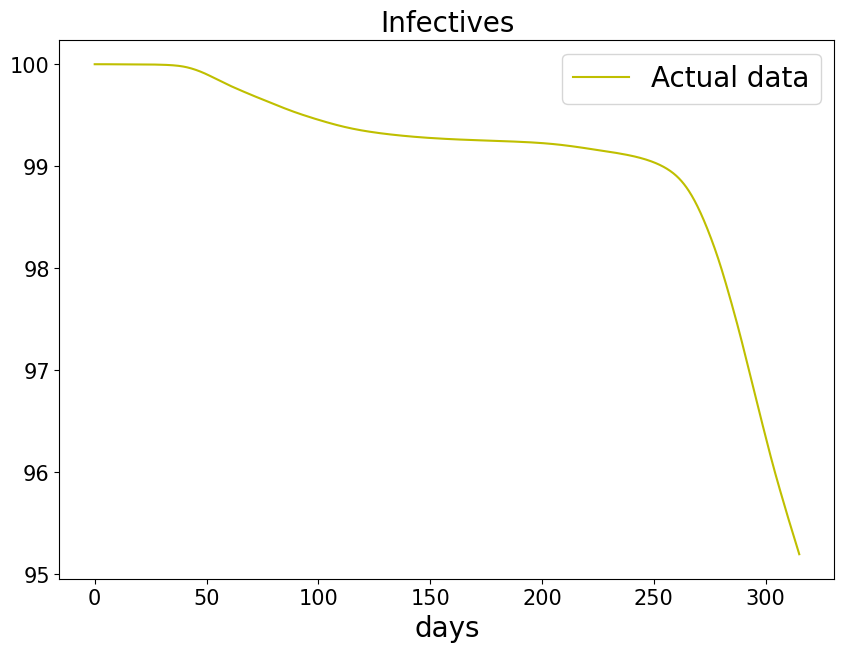

In [8]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
ax1.set_title('Infectives',fontsize = 20)
ax1.plot(T1, S1,'y',markevery=10)
ax1.set_xlabel('days',fontsize = 20)
ax1.legend(('Actual data','Predicted data'),loc='best',fontsize = 20)
ax1.tick_params(labelsize=15)

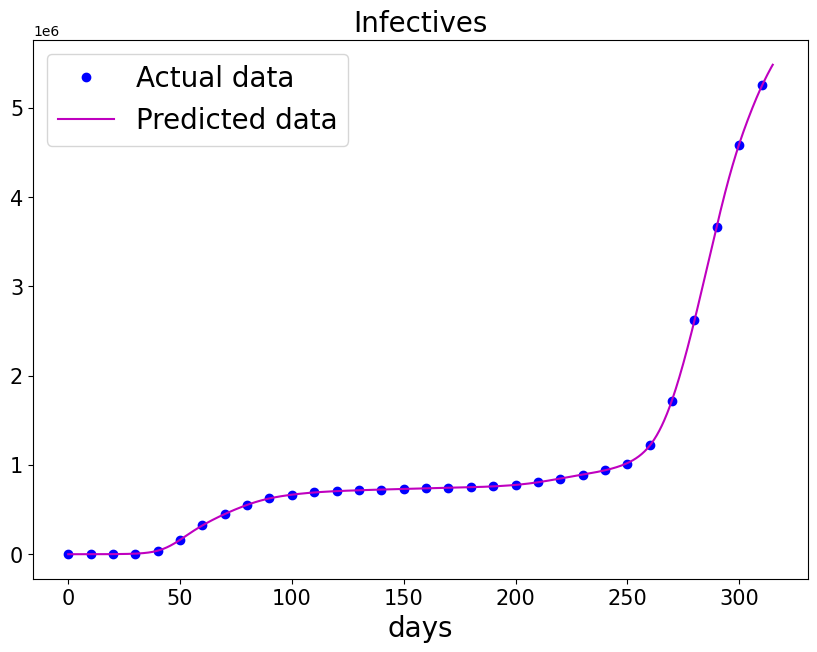

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
ax1.set_title('Infectives',fontsize = 20)
ax1.plot(T0, I0L,'bo',markevery=10)
ax1.plot(T1,I1L,'m')
ax1.set_xlabel('days',fontsize = 20)
ax1.legend(('Actual data','Predicted data'),loc='best',fontsize = 20)
ax1.tick_params(labelsize=15)

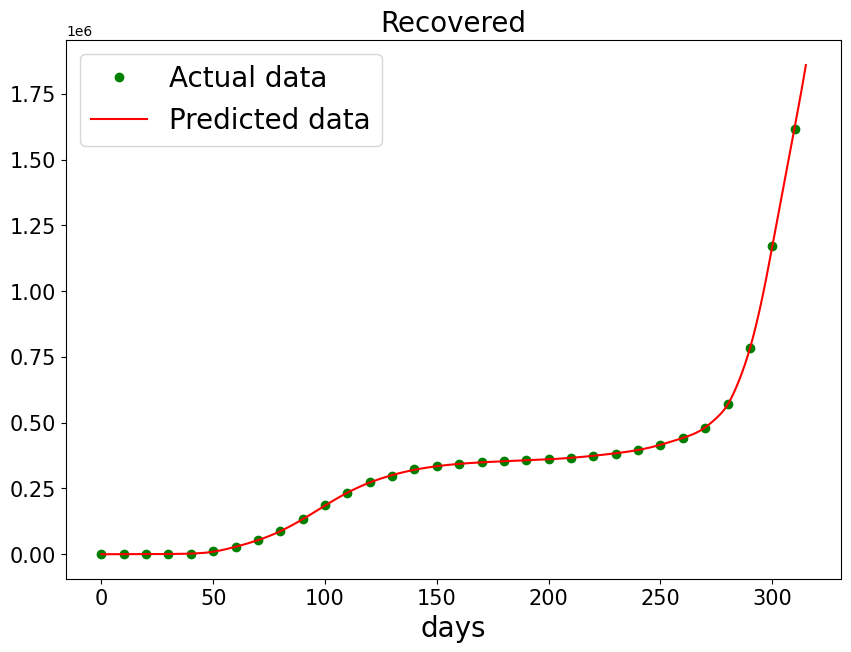

In [10]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
ax1.set_title('Recovered',fontsize = 20)
ax1.plot(T0,R0L,'go', markevery=10)
ax1.plot(T1,R1L,'r')
ax1.set_xlabel('days',fontsize = 20)
ax1.legend(('Actual data','Predicted data'),loc='best',fontsize = 20)
ax1.tick_params(labelsize=15)

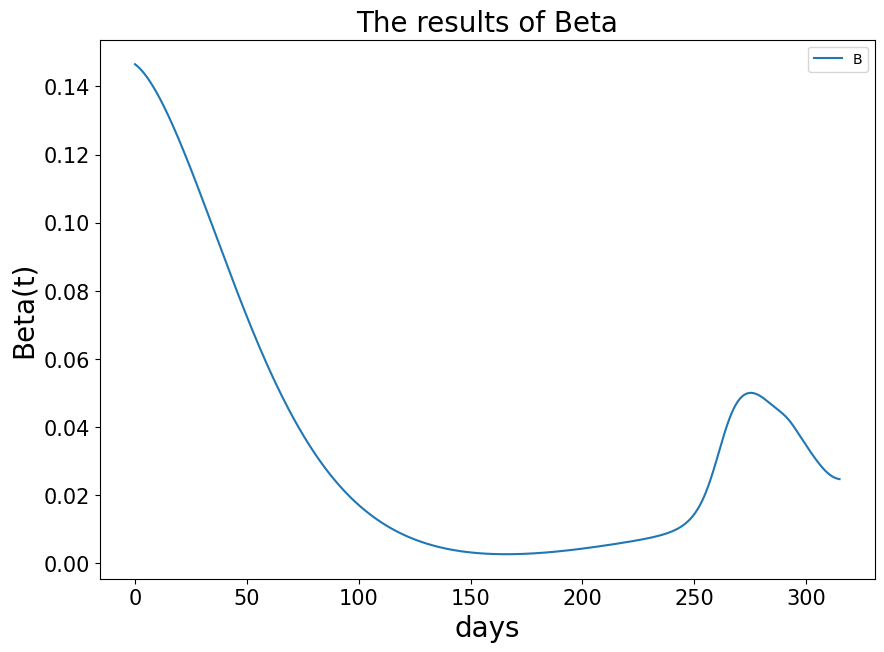

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
ax1.set_title('The results of Beta',fontsize = 20)
ax1.plot(T1, beta_pred.flatten())
ax1.set_xlabel('days',fontsize = 20)
ax1.set_ylabel('Beta(t)',fontsize = 20)
ax1.legend(('Beta'))
ax1.tick_params(labelsize=15)

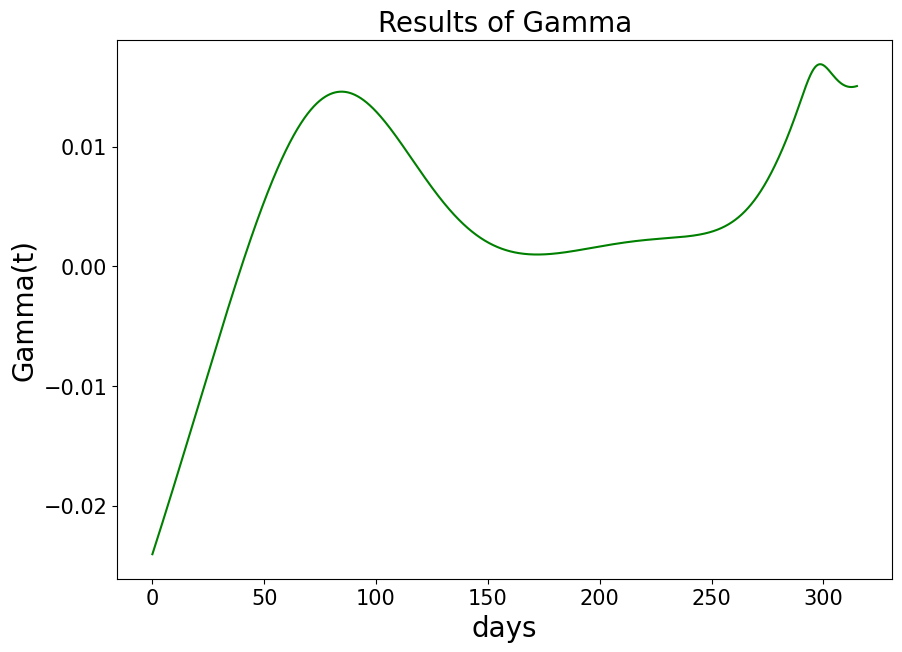

In [12]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))

ax1.set_title('Results of Gamma',fontsize = 20)
ax1.plot(T1, gamma_pred.flatten(), "g")
ax1.set_xlabel('days',fontsize = 20)
ax1.set_ylabel('Gamma(t)',fontsize = 20)
#ax1.legend(('Gamma Parameter'),loc='best',fontsize = 20)
#fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

Loss: 1.814482e-05


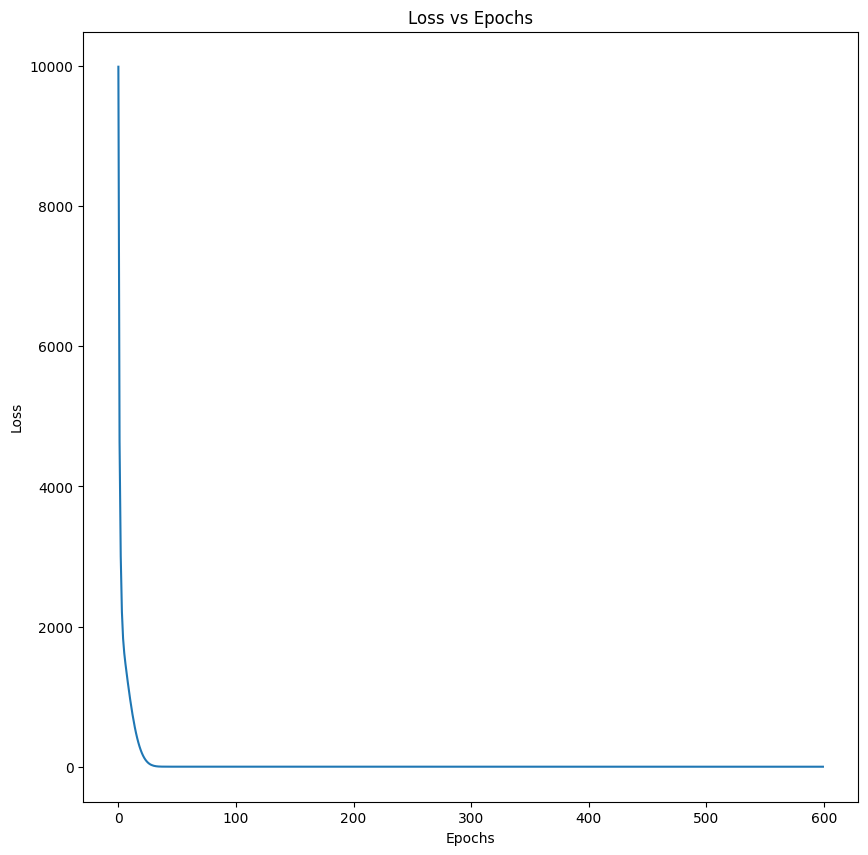

R^2 score for I: 0.9999840724693851
R^2 score for R: 0.999918207021062
MSE for I: 7.513957264159939e-06
MSE for R: 8.599264200660463e-06
MAE for I: 0.0013681241635822264
MAE for R: 0.0015047607320070248
EVS for I: 0.999984082518459
EVS for R: 0.9999182135799781
RMSE for I: 0.0027411598392213356
RMSE for R: 0.00293245020429341


In [13]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_train, model.I_tf: I_train, model.R_tf: R_train})
print("Loss:", loss)



# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_I = r2_score(I_train, I_pred)
r2_R = r2_score(R_train, R_pred)
print("R^2 score for I:", r2_I)
print("R^2 score for R:", r2_R)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_I = mean_squared_error(I_train, I_pred)
mse_R = mean_squared_error(R_train, R_pred)
print("MSE for I:", mse_I)
print("MSE for R:", mse_R)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_I = mean_absolute_error(I_train, I_pred)
mae_R = mean_absolute_error(R_train, R_pred)
print("MAE for I:", mae_I)
print("MAE for R:", mae_R)


# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_I = explained_variance_score(I_train, I_pred)
evs_R = explained_variance_score(R_train, R_pred)
print("EVS for I:", evs_I)
print("EVS for R:", evs_R)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_I = mean_squared_error(I_train, I_pred, squared=False)
rmse_R = mean_squared_error(R_train, R_pred, squared=False)
print("RMSE for I:", rmse_I)
print("RMSE for R:", rmse_R)


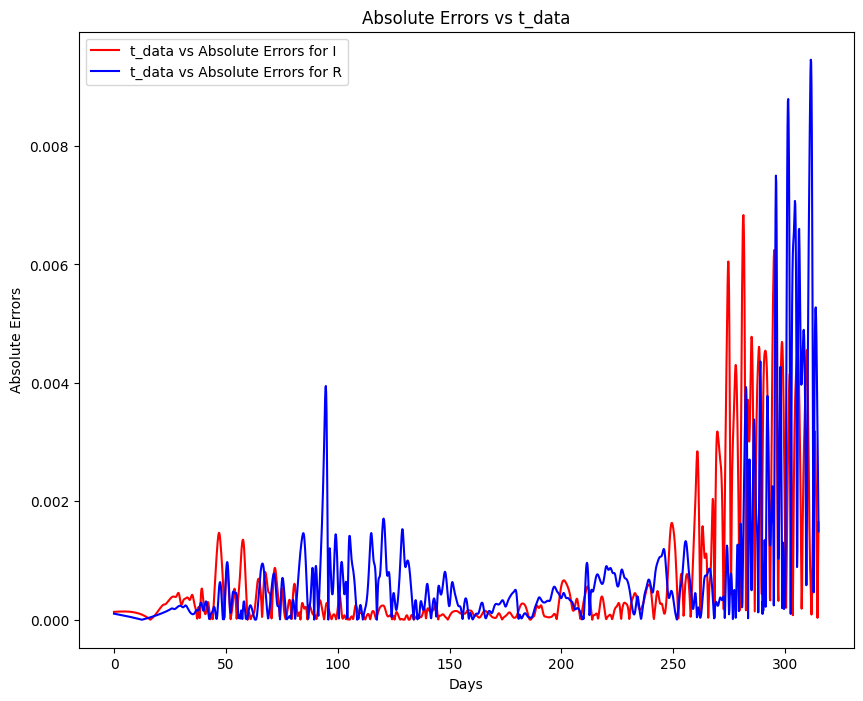

In [14]:
# plot the absolute errors between the target and the predictions and let it all start at zero
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_train, 1/2*(abs(I_train - I_pred)), 'r')
plt.plot(t_train, 1/2*(abs(R_train - R_pred)), 'b')
plt.xlabel('Days')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for I", "t_data vs Absolute Errors for R"])
plt.title("Absolute Errors vs t_data")
plt.show()

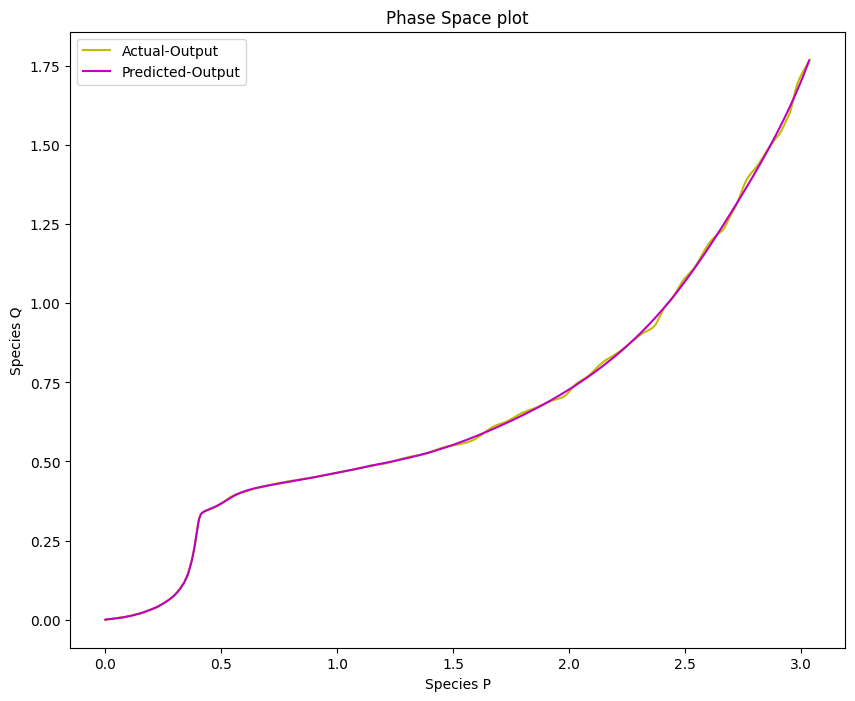

In [15]:
plt.rcParams['figure.figsize'] = [10,8]
plt.plot(I_train,R_train,'y')
plt.plot(I_pred,R_pred,'m')
plt.legend(["Actual-Output", "Predicted-Output"])
plt.xlabel('Species P')
plt.ylabel("Species Q")
plt.title("Phase Space plot")
plt.show()